# Preface
This notebook uses several packages from CRAN, as well as [Bioconductor](https://bioconductor.org). For a full list of attached packages see the session info in the Appendix at the end of this notebook. Several options have been adjusted to improve appearance of plots.

In [1]:
## Load necessary packages
suppressMessages({
    
    library("xcms")
    library("CAMERA")
    library("RColorBrewer")
    library("SummarizedExperiment")
    library("tidyverse")
    library("gplots")
    library("ggrepel")
    library("Rtsne")
    library("caret")
    library("MASS")
    
})

## Set session-specific options
options(repr.plot.width = 12, # Adjust plot width for publication purposes
        repr.plot.height = 8, # Adjust plot height for publication purposes,
        scipen = -1) # Adjust scientific notation of numbers to improve readability of plots

## List mzXML files
mzXMLs <- list.files(path = getwd(), recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

Warning message:
“replacing previous import ‘xcms::plot’ by ‘graphics::plot’ when loading ‘CAMERA’”
Warning message:
“package ‘caret’ was built under R version 4.0.2”


# Quality Control of Raw Data
The following injection order during analysis correspond to the order files are read using list.files. In case several batches were analysed, as vector containing an integer for each batch assignment of each sample must be given.

In [3]:
## List mzXML files
mzXMLs <- list.files(path = "PH_pos", recursive = TRUE, 
                     full.names = TRUE, pattern = ".mzXML")

## Aggregate meta data
sample.name <- sub(basename(mzXMLs), pattern = ".mzXML", 
                   replacement = "", fixed = TRUE)
sample.group <- c(rep("Blank", 5), rep("PCYP", 5), 
                  rep("QC", 5))
sample.order <- c(6,7,5,11,14,13,12,10,4,8,1,2,3,9,15)
sample.batch <- NA
meta <- data.frame(sample_name = sample.name, 
                   sample_group = sample.group, 
                   sample_order = sample.order, 
                   sample_batch = sample.batch, 
                   stringsAsFactors = FALSE)

## Read raw data from disk
raw <- readMSData(files = mzXMLs[order(sample.order)], 
                  pdata = new("AnnotatedDataFrame", 
                              meta[order(sample.order),]), 
                  mode = "onDisk")
## Remove column equilibration and washing phases
raw <- filterRt(raw, c(60,600))

class(raw)

print(raw)

[1] "OnDiskMSnExp"
attr(,"package")
[1] "MSnbase"

MSn experiment data ("OnDiskMSnExp")
Object size in memory: 4.42 Mb
- - - Spectra data - - -
 MS level(s): 1 
 Number of spectra: 15610 
 MSn retention times: 1:0 - 9:60 minutes
- - - Processing information - - -
Data loaded [Thu Oct 14 13:57:58 2021] 
Filter: select retention time [60-600] and MS level(s), 1 [Thu Oct 14 13:57:58 2021] 
 MSnbase version: 2.14.2 
- - - Meta data  - - -
phenoData
  rowNames: 11 12 ... 15 (15 total)
  varLabels: sample_name sample_group sample_order sample_batch
  varMetadata: labelDescription
Loaded from:
  [1] pQC_1.mzXML...  [15] pQC_5.mzXML
  Use 'fileNames(.)' to see all files.
protocolData: none
featureData
  featureNames: F01.S0117 F01.S0118 ... F15.S1157 (15610 total)
  fvarLabels: fileIdx spIdx ... spectrum (35 total)
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'


# Inspection of Parent Compound and Internal Standard
This experiment used deuterated tryptophan as an internal standard to normalise variability introduced by injection of the samples into the mass spectrometer. Quality control in at this stage includes ensuring that both the internal standard, as well as the parent compound, have been detected properly and the within group variability is acceptable.

In [4]:
## Define colours for experimental groups
group.colours <- paste0(brewer.pal(3, "Set1")[1:3])
names(group.colours) <- c("Blank", "PCYP", "QC")

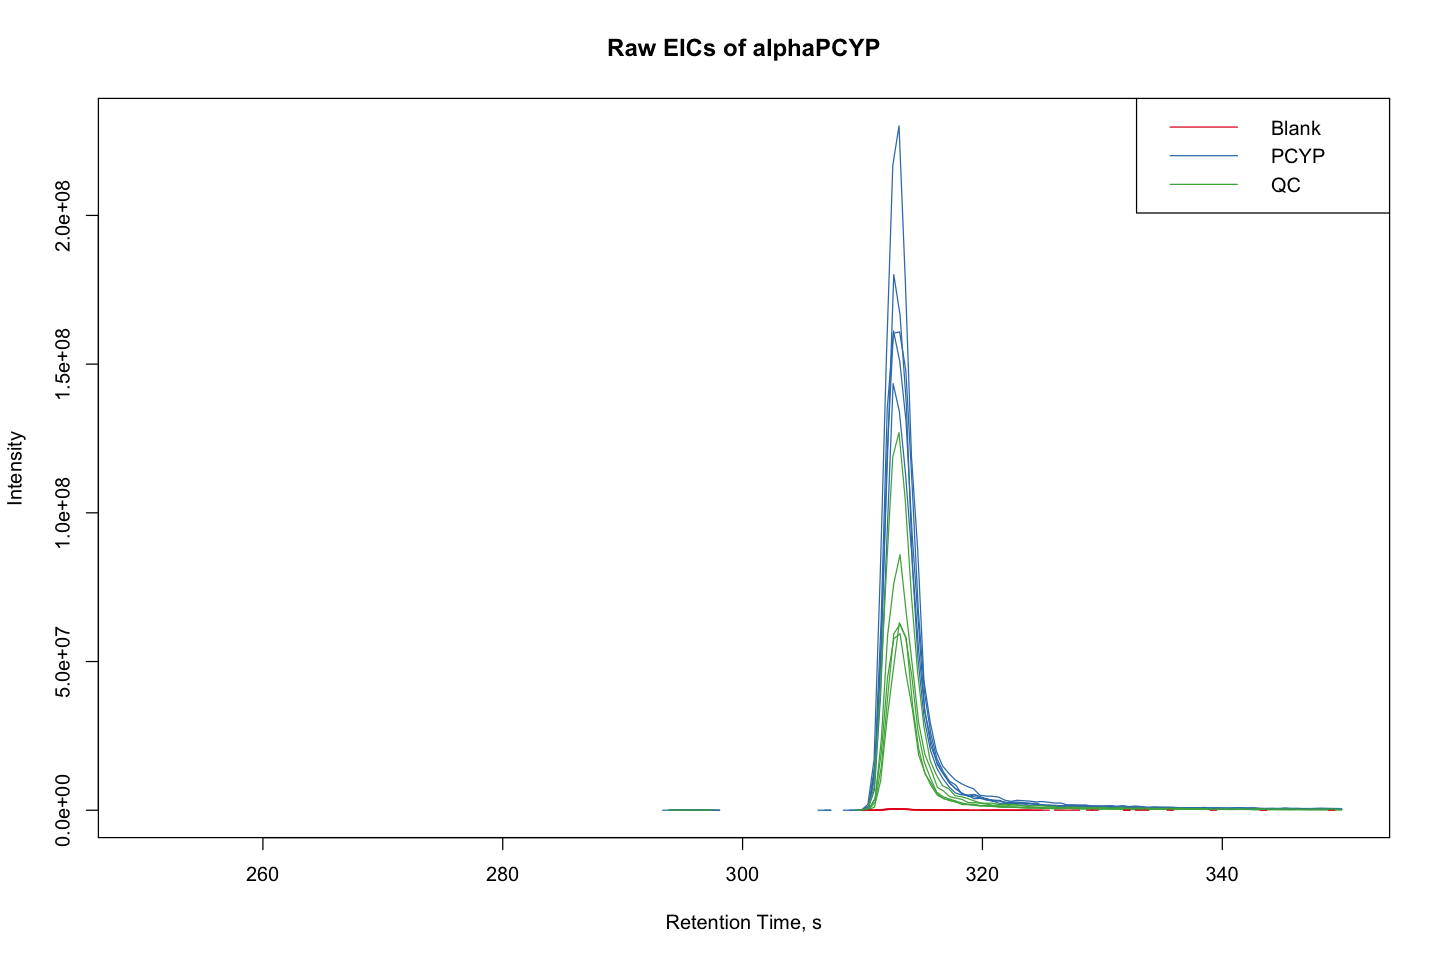

In [8]:
## Plot raw EICs of alpha-PCYP (m/z 272.2008, 25 s)
alphaPCYP.raw <- chromatogram(raw, mz = c(272.2000, 272.2015), rt = c(250, 350))

plot(cread3.raw, col = group.colours[alphaPCYP.raw$sample_group], 
     main = bquote(bold("Raw EICs of alphaPCYP")), xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Inspect Total Ion Currents of Sample Files

Total ion currents (TICs) need to be inspected in order to ensure that chromatography and mass spectrometry have been performing properly. Quality control includes the inspection of retention time drifts within TICS and evaluation of the baselines.

In [9]:
## Get total ion chromatograms
tics <- chromatogram(raw, aggregationFun = "sum")

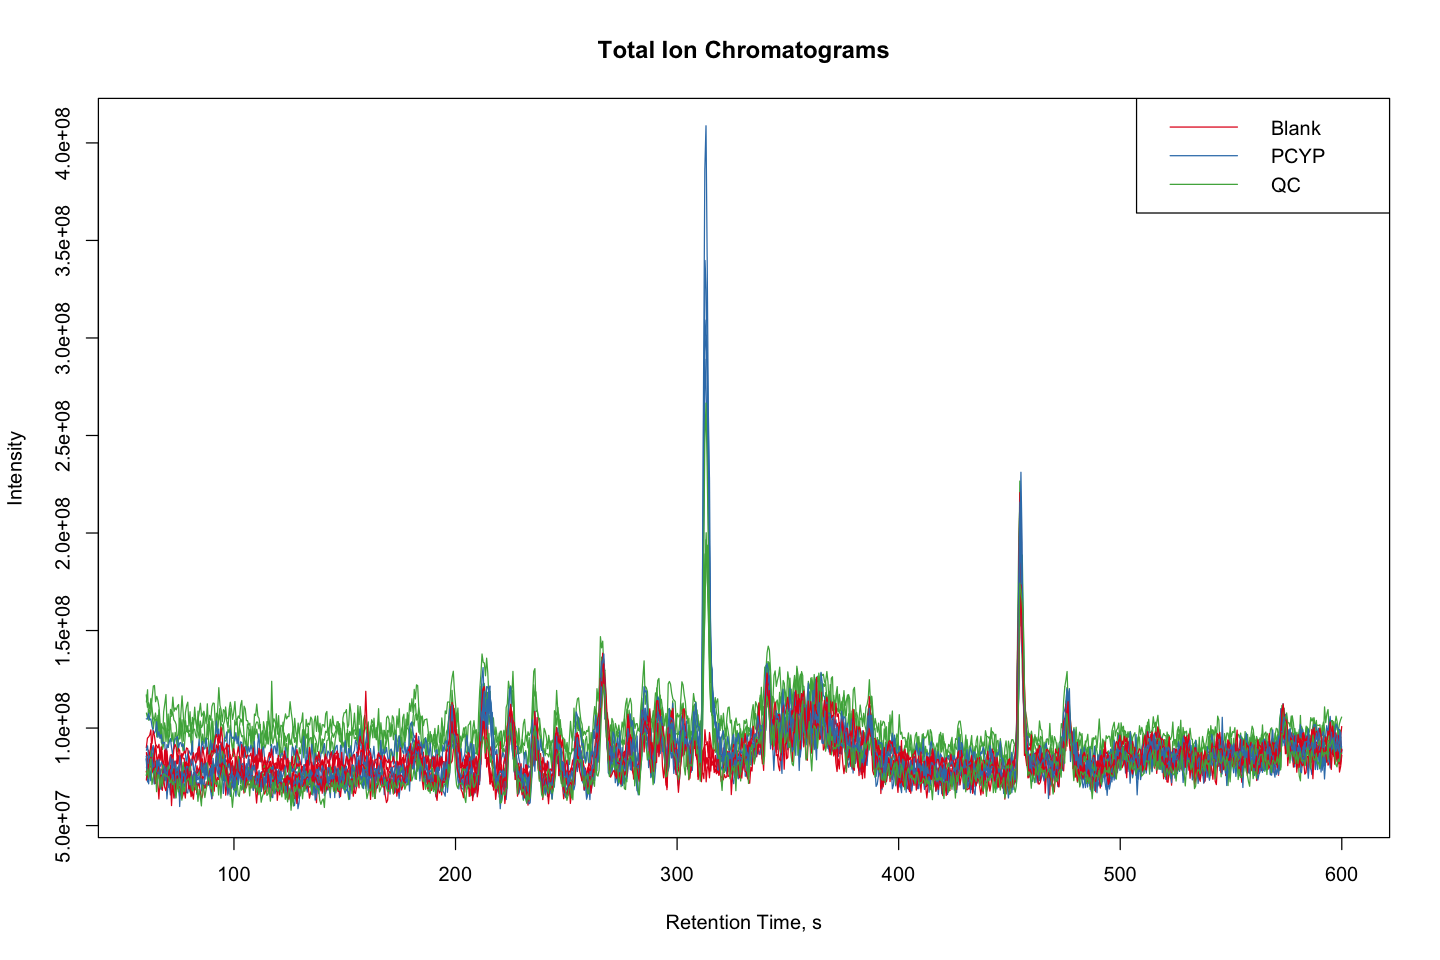

In [10]:
## Plot every total ion chromatogram of the data set
plot(tics, col = group.colours[raw$sample_group], 
     main = "Total Ion Chromatograms", ylab = "Intensity", 
     xlab = "Retention Time, s")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

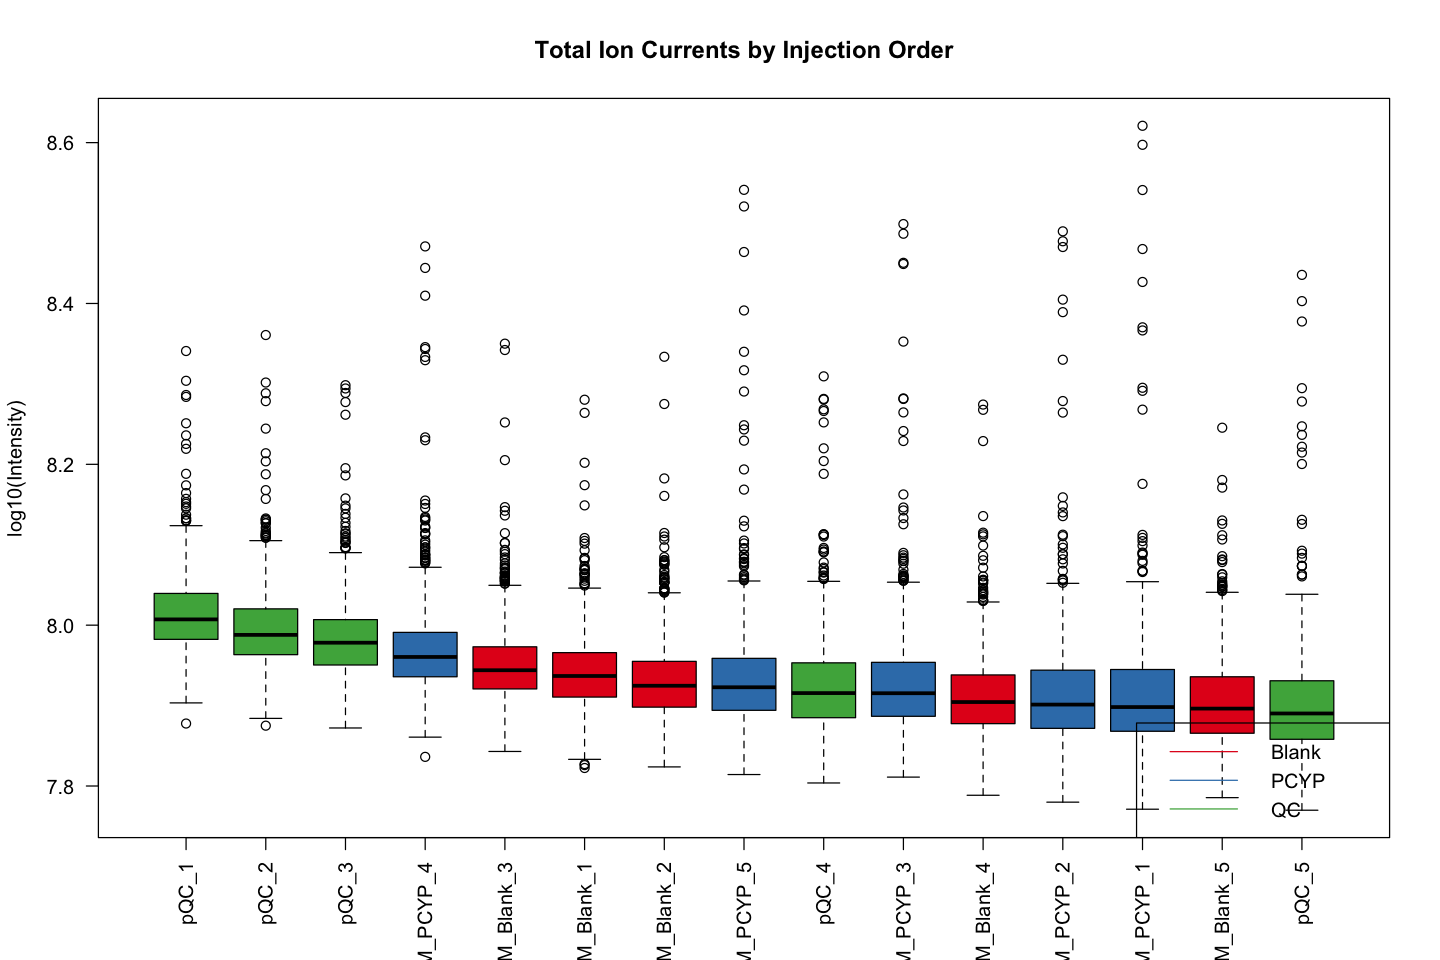

In [11]:
# Inspect boxplots of TICs by injection order
tics.summary <- split(tic(raw), f = fromFile(raw))

boxplot(sapply(tics.summary, log10), names = raw$sample_name, 
        col = group.colours[raw$sample_group], ylab = "log10(Intensity)", 
        main = "Total Ion Currents by Injection Order", las = 2)
legend("bottomright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Preprocessing of Raw Sample Files

# Peak Picking

Parameter used in this section were obtained using the one-by-one optimization performed by centWaveOpt. This approach was published at DOI: 10.1002/dta.2552 by Manier et al.

In [12]:
cwp <- CentWaveParam(peakwidth = c(8.9, 100), ppm = 1.8, snthresh = 10, 
                     mzdiff = 0.018,  prefilter = c(7, 100))

suppressMessages(
    
    set <- findChromPeaks(raw, param = cwp)
    
    )

In [13]:
## Define sample colours
sample.colours <- paste0(brewer.pal(3, "Set1")[1:3], "60")
names(sample.colours) <- c("Blank", "PCYP", "QC")
sample.colours <- sample.colours[raw$sample_group]

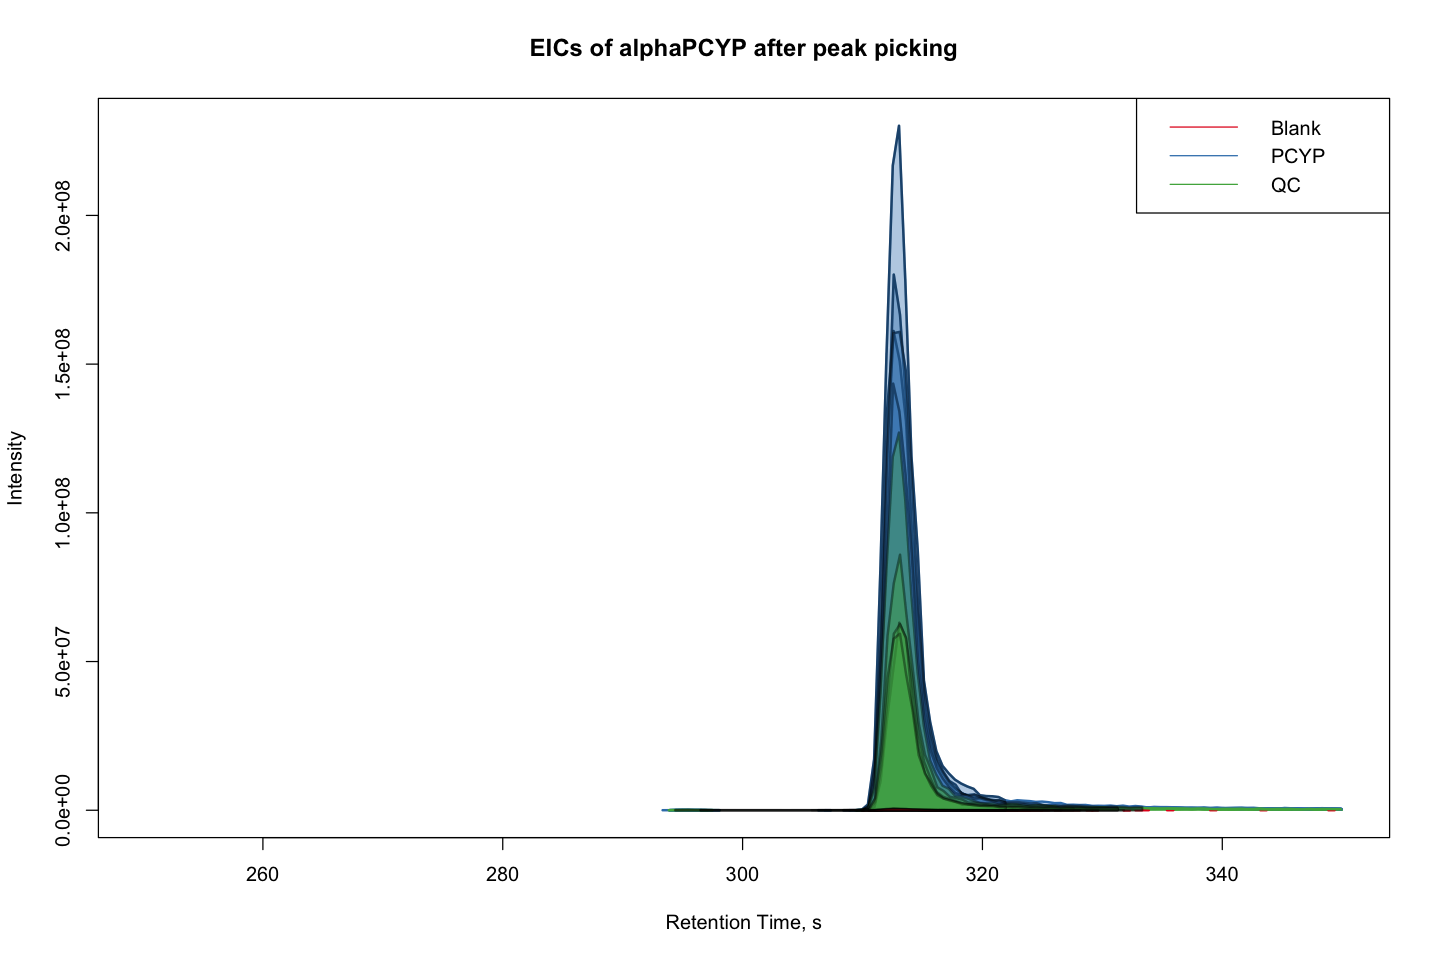

In [14]:
## Plot alpha-PCYP after peak picking (m/z 272.2008, 314 s)
alphaPCYP.picked <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(250, 350)) 

plot(alphaPCYP.picked, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.picked)[, "sample"]],
     main = bquote(bold("EICs of alphaPCYP"*" after peak picking")), xlab = "Retention Time, s",
     ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Retention Time Correction

In [16]:
suppressMessages({
    
    set <- adjustRtime(set, param = ObiwarpParam(binSize = 0.6))
    set <- dropAdjustedRtime(set)

    pdp <- PeakDensityParam(sampleGroups = set$sample_group, bw = 5)
    set <- groupChromPeaks(set, param = pdp)

    ## Define subset alignment options and perform the alignment
    pgp <- PeakGroupsParam(minFraction = 0.8, 
                           subset = which(set$sample_group == "QC"),
                           subsetAdjust = "average", span = 0.2)
    set <- adjustRtime(set, param = pgp)
    
})

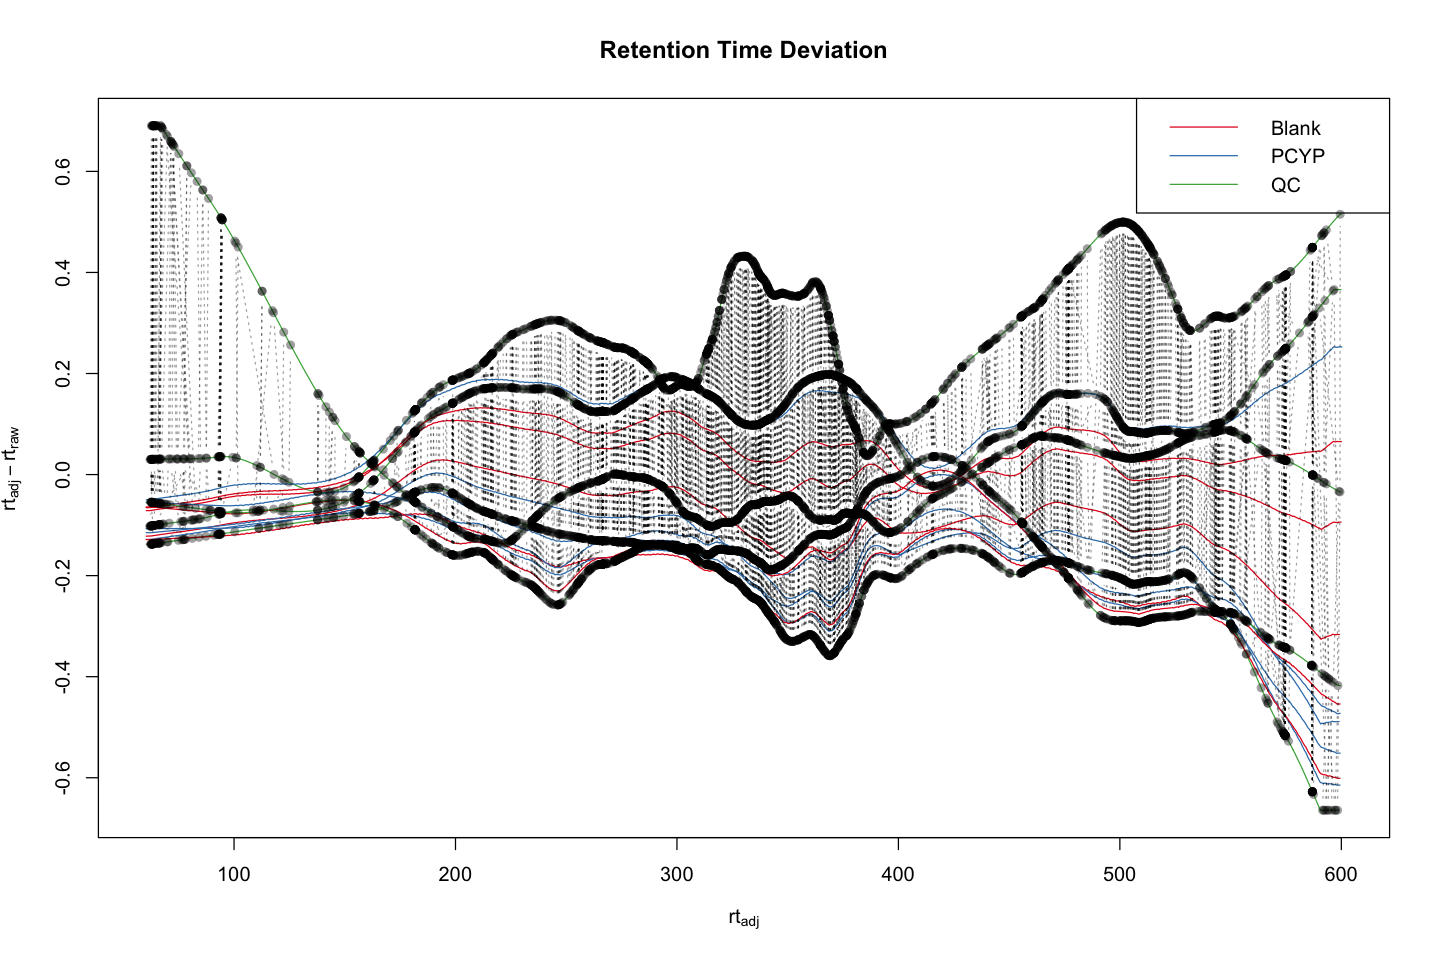

In [17]:
## Plot difference of adjusted to raw retention time.
plotAdjustedRtime(set, col = group.colours[set$sample_group], 
                  main = "Retention Time Deviation")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

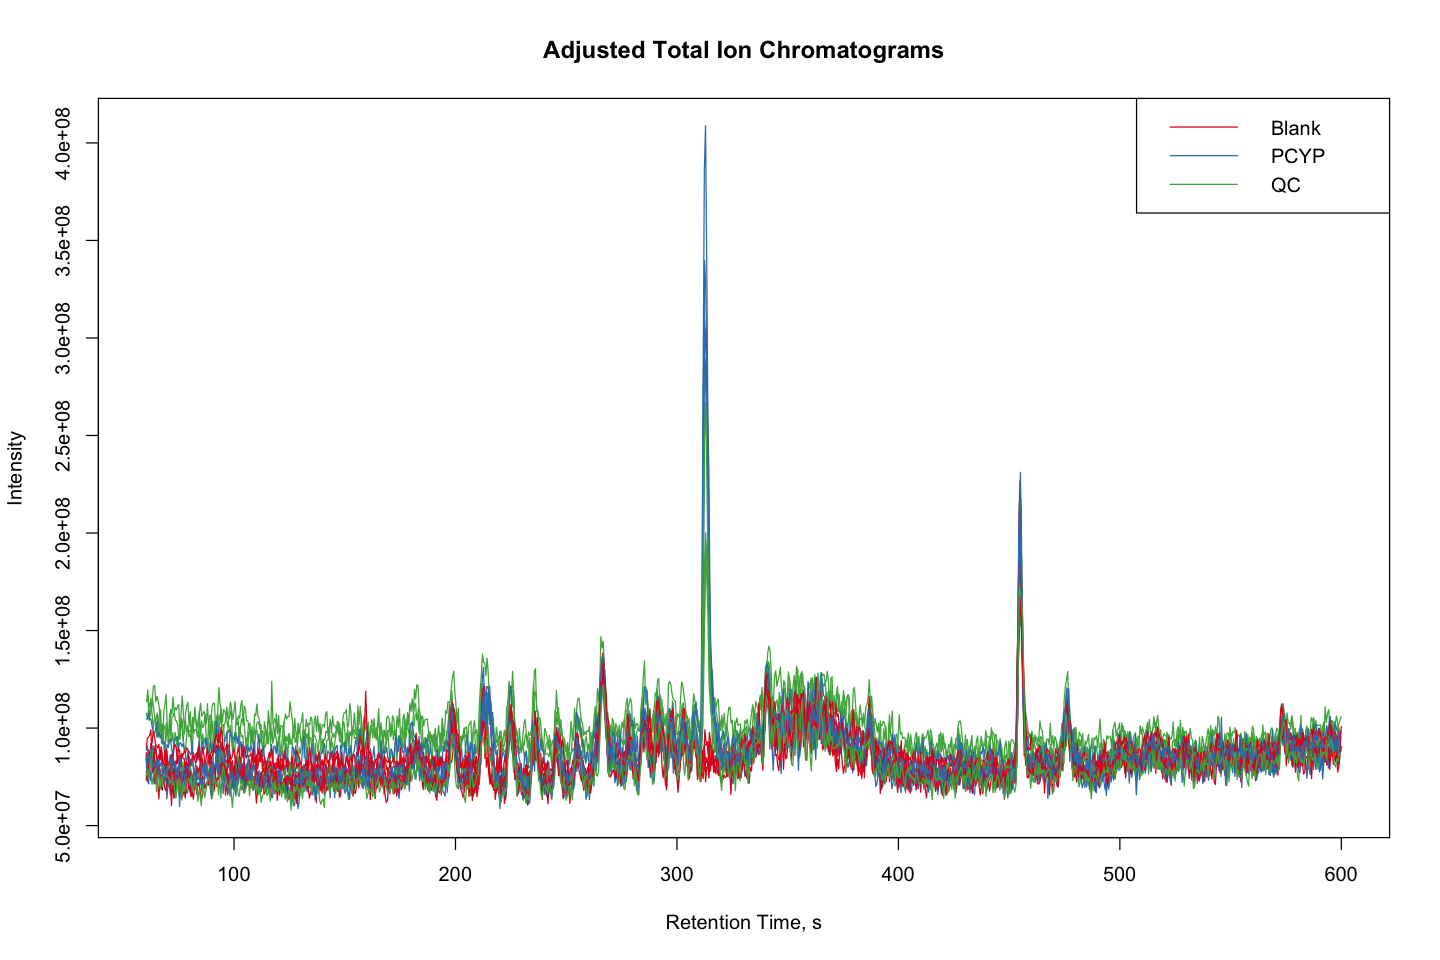

In [18]:
## Get the retention time-adjusted total ion chromatograms.
tics.corr <- chromatogram(set, aggregationFun = "sum")

plot(tics.corr, col = group.colours[tics.corr$sample_group], 
     peakType = "none", main = "Adjusted Total Ion Chromatograms", 
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), col = group.colours, lty = 1)

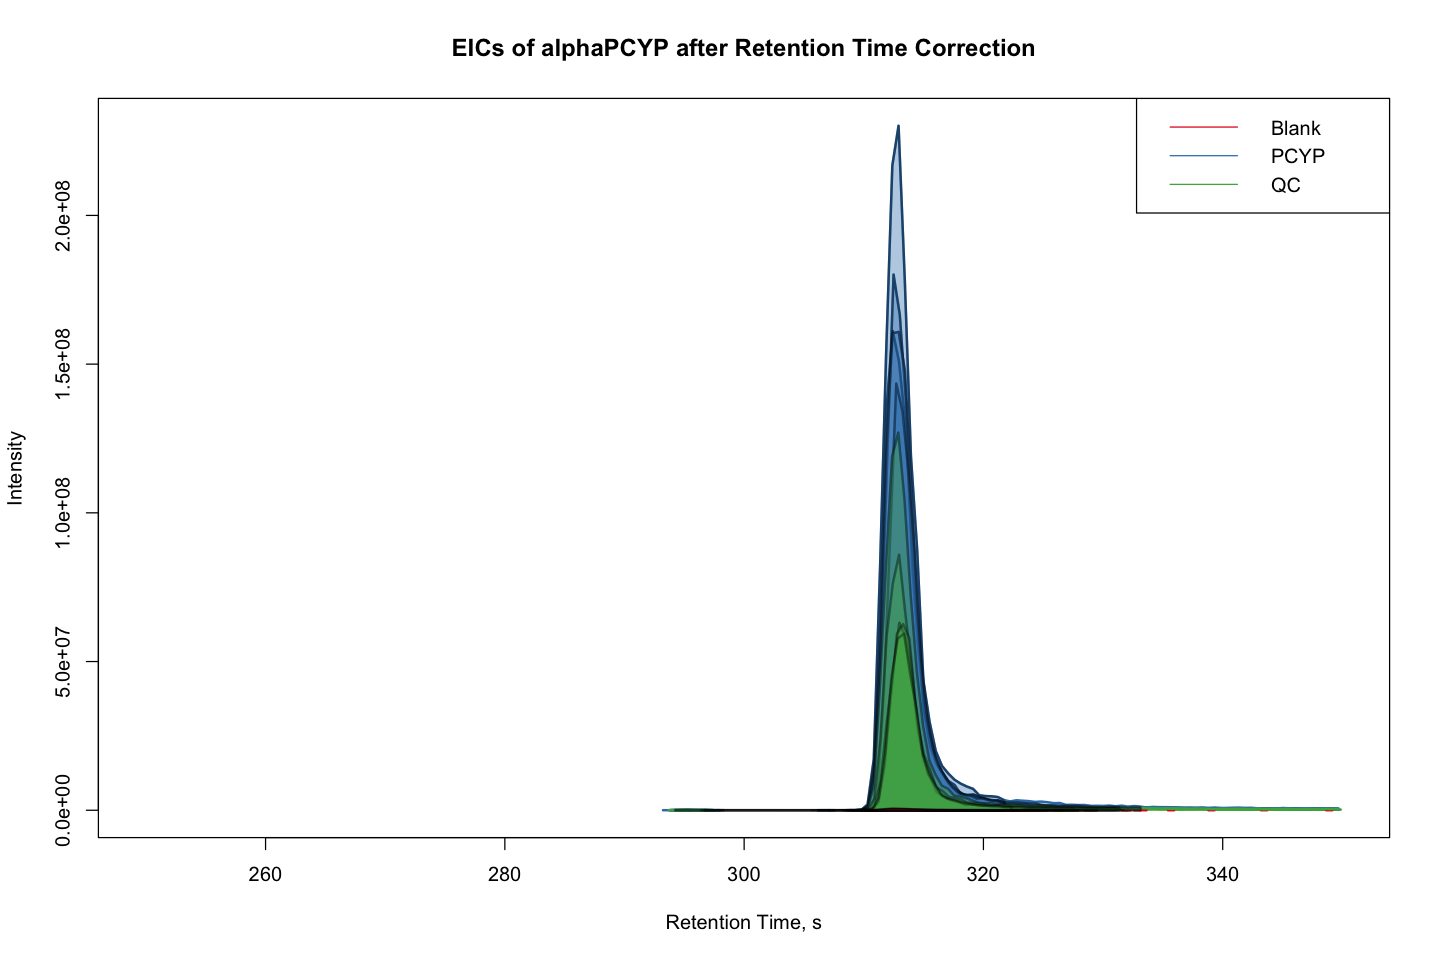

In [19]:
## Plot alpha-PCYP after retention time correction (m/z 272.2008, 314 s)
alphaPCYP.corr <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(250, 350))

plot(alphaPCYP.corr, col = group.colours[alphaPCYP.raw$sample_group], lwd = 2,
     peakBg = sample.colours[chromPeaks(alphaPCYP.corr)[, "sample"]],
     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Retention Time Correction")),
     xlab = "Retention Time, s", ylab = "Intensity")
legend("topright", legend = names(group.colours), 
       col = group.colours, lty = 1)

# Peak Grouping

In [20]:
suppressMessages(
    
    set <- groupChromPeaks(set, param = pdp)
    
)

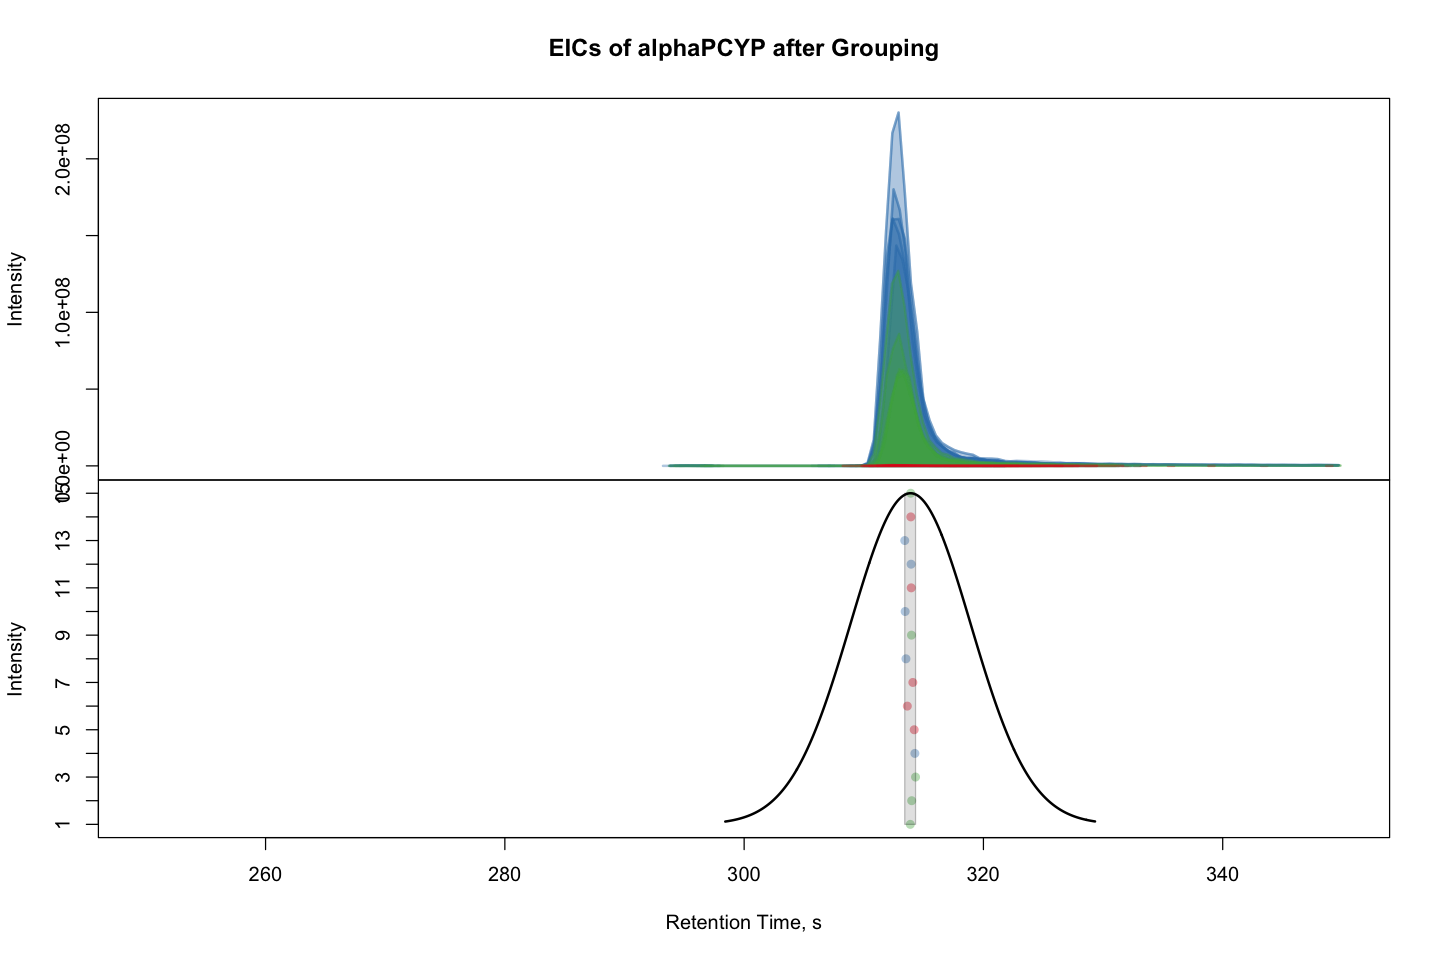

In [21]:
## Plot alpha-PCYP after peak grouping
alphaPCYP.grouped <- chromatogram(set, mz = c(272.2000, 272.2015), rt = c(250, 350))

## Define the parameters for the peak density method
plotChromPeakDensity(alphaPCYP.grouped, col = sample.colours, param = pdp, lwd = 2,
                     peakBg = sample.colours[chromPeaks(alphaPCYP.grouped)[, "sample"]],
                     peakCol = sample.colours[chromPeaks(alphaPCYP.grouped)[, "sample"]],
                     peakPch = 16, main = bquote(bold("EICs of alphaPCYP"*" after Grouping")),
                     xlab = "Retention Time, s", ylab = "Intensity")

# Peak Filling

In [22]:
suppressMessages(    
     
    set <- fillChromPeaks(set, param = ChromPeakAreaParam())
    
)

ERROR: Error in h(simpleError(msg, call)): Fehler bei der Auswertung des Argumentes 'param' bei der Methodenauswahl für Funktion 'fillChromPeaks': konnte Funktion "ChromPeakAreaParam" nicht finden


# Postprocessing


# Annotation of Adducts and Isotopes

In [23]:
## Summarise experiment
results <- quantify(set, value = "into")
class(results)

[1] "SummarizedExperiment"
attr(,"package")
[1] "SummarizedExperiment"

In [24]:
rowData(results) %>%
head()

DataFrame with 6 rows and 12 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   59.0501   59.0500   59.0501   293.708   292.728   294.072        15
FT0002   59.0501   59.0500   59.0502   336.918   336.516   337.496        15
FT0003   59.0501   59.0500   59.0502   156.445   155.931   156.939        15
FT0004   73.0656   73.0655   73.0657   207.314   206.979   207.909        15
FT0005   73.4541   73.4394   73.4866   198.991   197.339   213.097         6
FT0006   73.4673   73.4502   73.5054   464.657   455.603   468.809         6
           Blank      PCYP        QC               peakidx  ms_level
       <numeric> <numeric> <numeric>                <list> <integer>
FT0001         5         5         5     477,2325,4168,...         1
FT0002         5         5         5     777,2622,4484,...         1
FT0003         5         5         5      83,1944,3758,...         1
FT

In [25]:
## Add classic feature names
rowData(results)$label <- paste0("M",round(rowData(results)$mzmed,0),
                           "T", round(rowData(results)$rtmed,0))
rowData(results) %>%
head()

DataFrame with 6 rows and 13 columns
           mzmed     mzmin     mzmax     rtmed     rtmin     rtmax    npeaks
       <numeric> <numeric> <numeric> <numeric> <numeric> <numeric> <numeric>
FT0001   59.0501   59.0500   59.0501   293.708   292.728   294.072        15
FT0002   59.0501   59.0500   59.0502   336.918   336.516   337.496        15
FT0003   59.0501   59.0500   59.0502   156.445   155.931   156.939        15
FT0004   73.0656   73.0655   73.0657   207.314   206.979   207.909        15
FT0005   73.4541   73.4394   73.4866   198.991   197.339   213.097         6
FT0006   73.4673   73.4502   73.5054   464.657   455.603   468.809         6
           Blank      PCYP        QC               peakidx  ms_level
       <numeric> <numeric> <numeric>                <list> <integer>
FT0001         5         5         5     477,2325,4168,...         1
FT0002         5         5         5     777,2622,4484,...         1
FT0003         5         5         5      83,1944,3758,...         1
FT

In [26]:
assay(results) %>% 
head()

,pQC_1.mzXML,pQC_2.mzXML,pQC_3.mzXML,HLM_PCYP_4.mzXML,HLM_Blank_3.mzXML,HLM_Blank_1.mzXML,HLM_Blank_2.mzXML,HLM_PCYP_5.mzXML,pQC_4.mzXML,HLM_PCYP_3.mzXML,HLM_Blank_4.mzXML,HLM_PCYP_2.mzXML,HLM_PCYP_1.mzXML,HLM_Blank_5.mzXML,pQC_5.mzXML
FT0001,747541.2,822980.9,707109.9,207591.7,765795.2,965597.1,893423.57,782348.9,852656.2,944430.5,1158795.0,919771.0,866912.3,970092.5,809366.6
FT0002,691827.9,877104.9,852406.9,655917.9,770892.6,769965.0,647101.51,990920.8,778789.3,970435.0,824666.9,695709.4,647789.6,899599.6,910087.3
FT0003,1249963.8,1229239.9,839501.0,932932.1,1154343.1,953031.8,1030895.43,1177304.6,1151080.7,1259330.3,1365753.0,1001278.8,1069168.3,1129904.5,1093623.3
FT0004,1920040.0,3547722.4,2342416.6,2407484.3,3331520.8,2151425.1,3205075.10,4137112.9,2016580.6,2768688.9,2799875.8,2811493.4,2654966.1,2426469.9,2159004.6
FT0005,NA,NA,NA,139892.1,178091.7,NA,74665.68,NA,125358.9,NA,116133.2,NA,NA,NA,NA
FT0006,NA,NA,NA,NA,212978.4,222463.8,NA,NA,NA,183723.0,203525.4,NA,241320.2,135615.3,NA


In [27]:
## Perform annotation using CAMERA
suppressMessages({
    
    camera <- set %>%
              as("xcmsSet") %>%
              CAMERA::annotate(polarity  = "positive") %>%
              getPeaklist() %>%
              dplyr::select(isotopes, adduct, pcgroup)
    
})

## Save annotation results in SummarizedExperiment class
rowData(results)$isotopes <- camera$isotopes
rowData(results)$adduct <- camera$adduct
rowData(results)$pcgroup <- camera$pcgroup

Start grouping after retention time.
Created 84 pseudospectra.
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 498 
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 84 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 84 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1168 
xsAnnotate has now 1168 groups, instead of 84 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1168 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


# Scaling

Before log10 transformation, every NA in the data matrix is replaced by the surrogate LOD according to Wehrens et al. at DOI: 10.1007/s11306-016-1015-8. The surrogate LOD is the lowest area that was measured during the analysis.

In [28]:
assays(results)

List of length 1
names(1): raw

In [29]:
# Replacing 0s with surrogate LOD
lod <- assay(results, "raw")[is.na(assay(results, "raw")) == FALSE] %>%
       min()
assay(results, "raw")[is.na(assay(results, "raw"))] <- lod

# Create assay results after log10 transformation
assay(results, "scaled") <- assay(results, "raw") %>%
                            log10()

In [30]:
assays(results)

List of length 2
names(2): raw scaled

In [31]:
results %>%
assay("scaled") %>%
head()

,pQC_1.mzXML,pQC_2.mzXML,pQC_3.mzXML,HLM_PCYP_4.mzXML,HLM_Blank_3.mzXML,HLM_Blank_1.mzXML,HLM_Blank_2.mzXML,HLM_PCYP_5.mzXML,pQC_4.mzXML,HLM_PCYP_3.mzXML,HLM_Blank_4.mzXML,HLM_PCYP_2.mzXML,HLM_PCYP_1.mzXML,HLM_Blank_5.mzXML,pQC_5.mzXML
FT0001,5.873635,5.915390,5.849487,5.317210,5.884113,5.984796,5.951057,5.893400,5.930774,5.975170,6.064007,5.963680,5.937975,5.986813,5.908145
FT0002,5.839998,5.943052,5.930647,5.816849,5.886994,5.886471,5.810972,5.996039,5.891420,5.986966,5.916279,5.842428,5.811434,5.954049,5.959083
FT0003,6.096897,6.089637,5.924021,5.969850,6.062335,5.979107,6.013215,6.070889,6.061106,6.100140,6.135372,6.000555,6.029046,6.053042,6.038868
FT0004,6.283310,6.549950,6.369664,6.381563,6.522643,6.332726,6.505838,6.616697,6.304616,6.442274,6.447139,6.448937,6.424059,6.384975,6.334254
FT0005,4.450301,4.450301,4.450301,5.145793,5.250644,4.450301,4.873121,4.450301,5.098155,4.450301,5.064956,4.450301,4.450301,4.450301,4.450301
FT0006,4.450301,4.450301,4.450301,4.450301,5.328336,5.347259,4.450301,4.450301,4.450301,5.264163,5.308619,4.450301,5.382594,5.132309,4.450301


# Normalisation

In [76]:
## Define function to calculate ppm deviation
ppm <- function(x,y) {

    return(10^6 * (x - y) / y)

}

## Define function to identify row of compound
identify <- function(data, mz, rt, ppmlim, rtlim) {

    delta.mz <- abs(mapply(ppm, x = data$mzmed, y = mz))
    delta.rt <- abs(data$rtmed - rt)
    return(which(delta.mz < ppmlim & delta.rt < rtlim))
    
}

In [80]:
## Identify rownumber of internal standard tryptophan-d5
trpd5 <- results %>%
         rowData() %>%
         as.data.frame() %>%
         identify(mz = 210.1291, rt = 148, 5, 10)

In [81]:
## Normalise data to internal standard
norm.is <- function(x, is){x/x[is]}
assay(results, "norm") <- apply(assay(results, "scaled"),2, norm.is, is = trpd5)

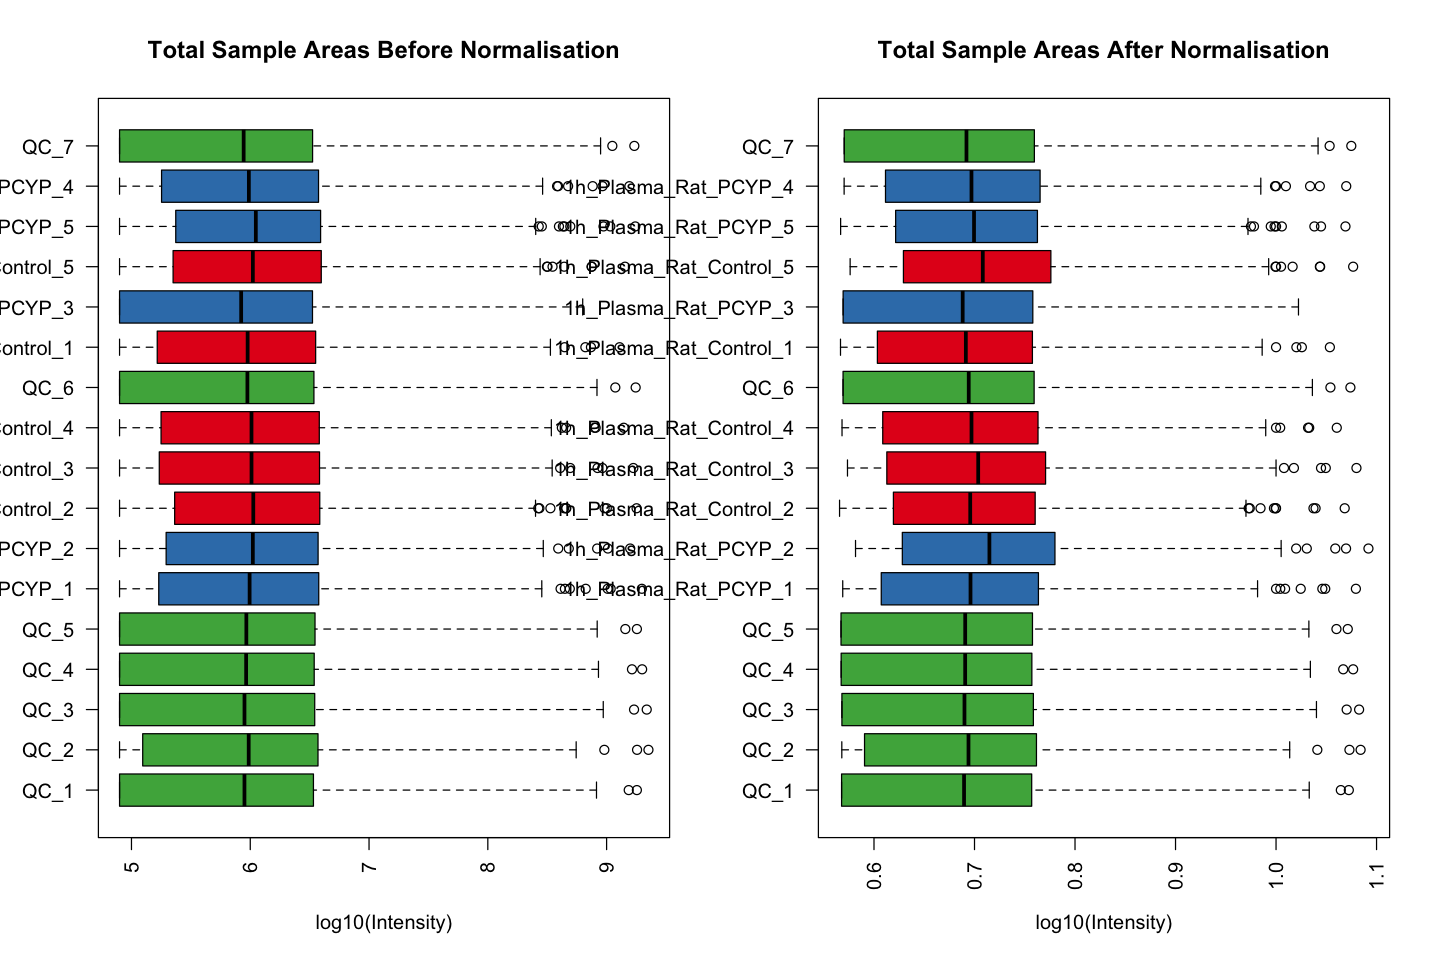

In [82]:
## Compare normalised and unnormalised data
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Normalisation", las = 2)

results %>%
assay("norm") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Normalisation", las = 2)

# Batch correction

In [32]:
## Define function to perform batch correction
batchCorrection <-function(area, order, group, output = c("df", "corr")) {
        
    df <- data.frame(order = order, area = area)
    model <- lm(area ~ order, data = df[group == "QC",])
    df$pred <- predict(model, newdata = df)
    df$corr <- df$corr <- df$area - df$pred + mean (df$area)
    return(switch(output, df = df, corr = df$corr))
    
}

In [33]:
## Filter features by detectability in QC samples
#results.filtered <- results[rowData(results)$QC == 9,]

In [34]:
## Perform batch correction
assay(results, "batchcorr",
      withDimnames = FALSE) <- apply(assay(results, "scaled"), 
                                     1, batchCorrection, 
                                     order = set$sample_order, 
                                     group = set$sample_group, 
                                     output = "corr") %>%
                                     t()

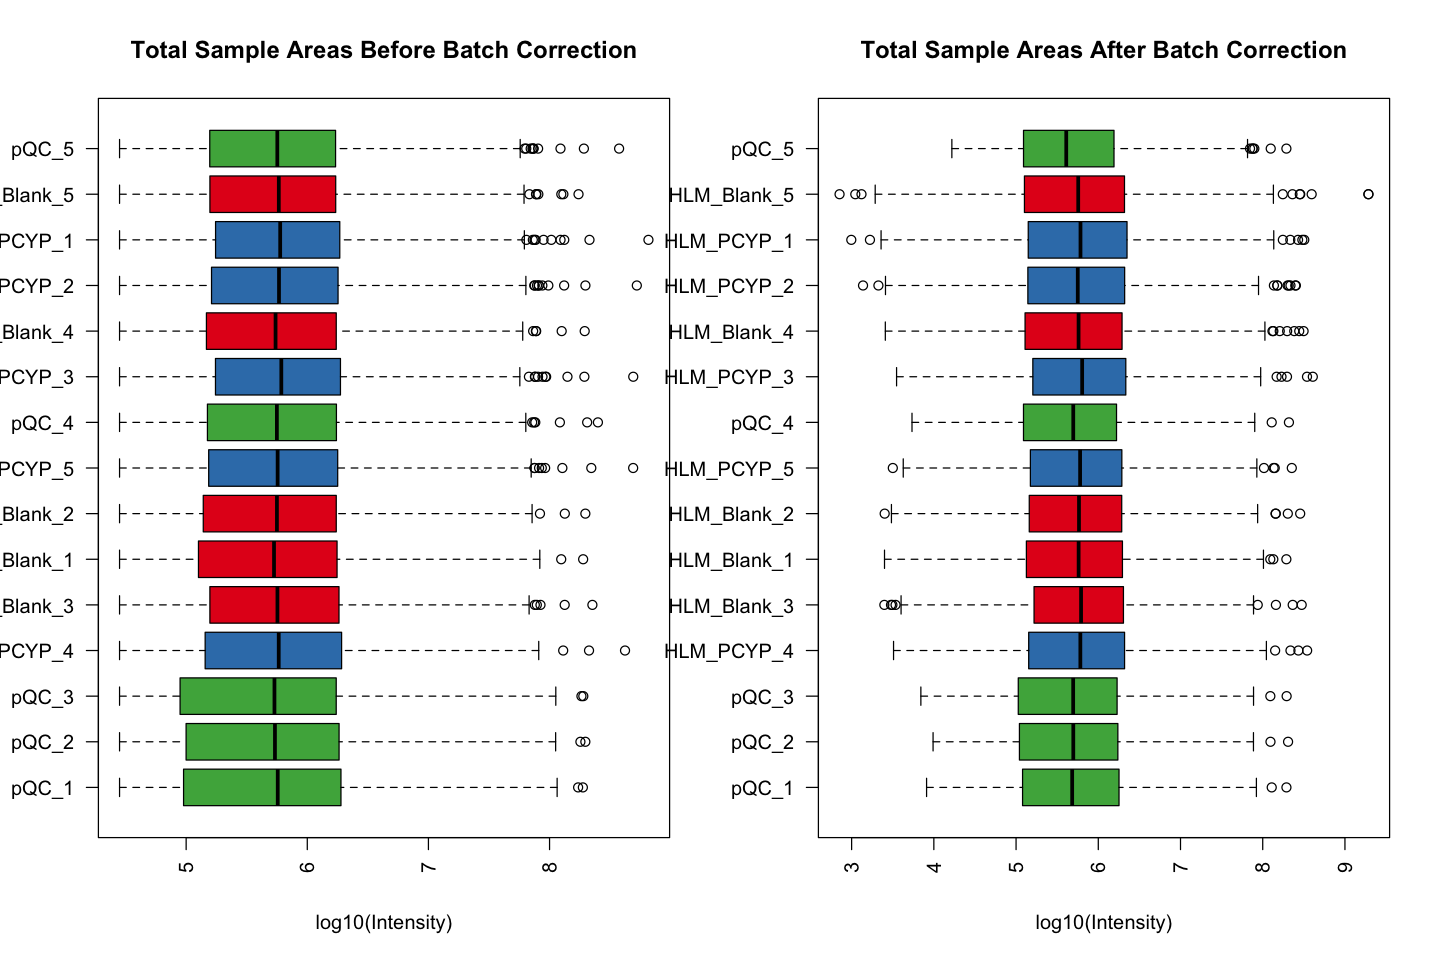

In [35]:
## Compare batch-corrected and uncorrected total sample areas
par(mfrow = c(1,2))

results %>%
assay("scaled") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas Before Batch Correction", las = 2)

results %>%
assay("batchcorr") %>%
boxplot(names = results$sample_name, horizontal = TRUE,
        col = group.colours[results$sample_group], xlab = "log10(Intensity)", 
        main = "Total Sample Areas After Batch Correction", las = 2)

In [36]:
## Compare batch-corrected and uncorrected areas of compounds
df <- batchCorrection(assay(results, "scaled")[51,], 
                      set$sample_order, set$sample_group, "df")

## Perform regression using corrected values
lm <- lm(area ~ order, data = df[results$sample_group == "QC",])
lm.new <- lm(corr ~ order, data = df[results$sample_group == "QC",])

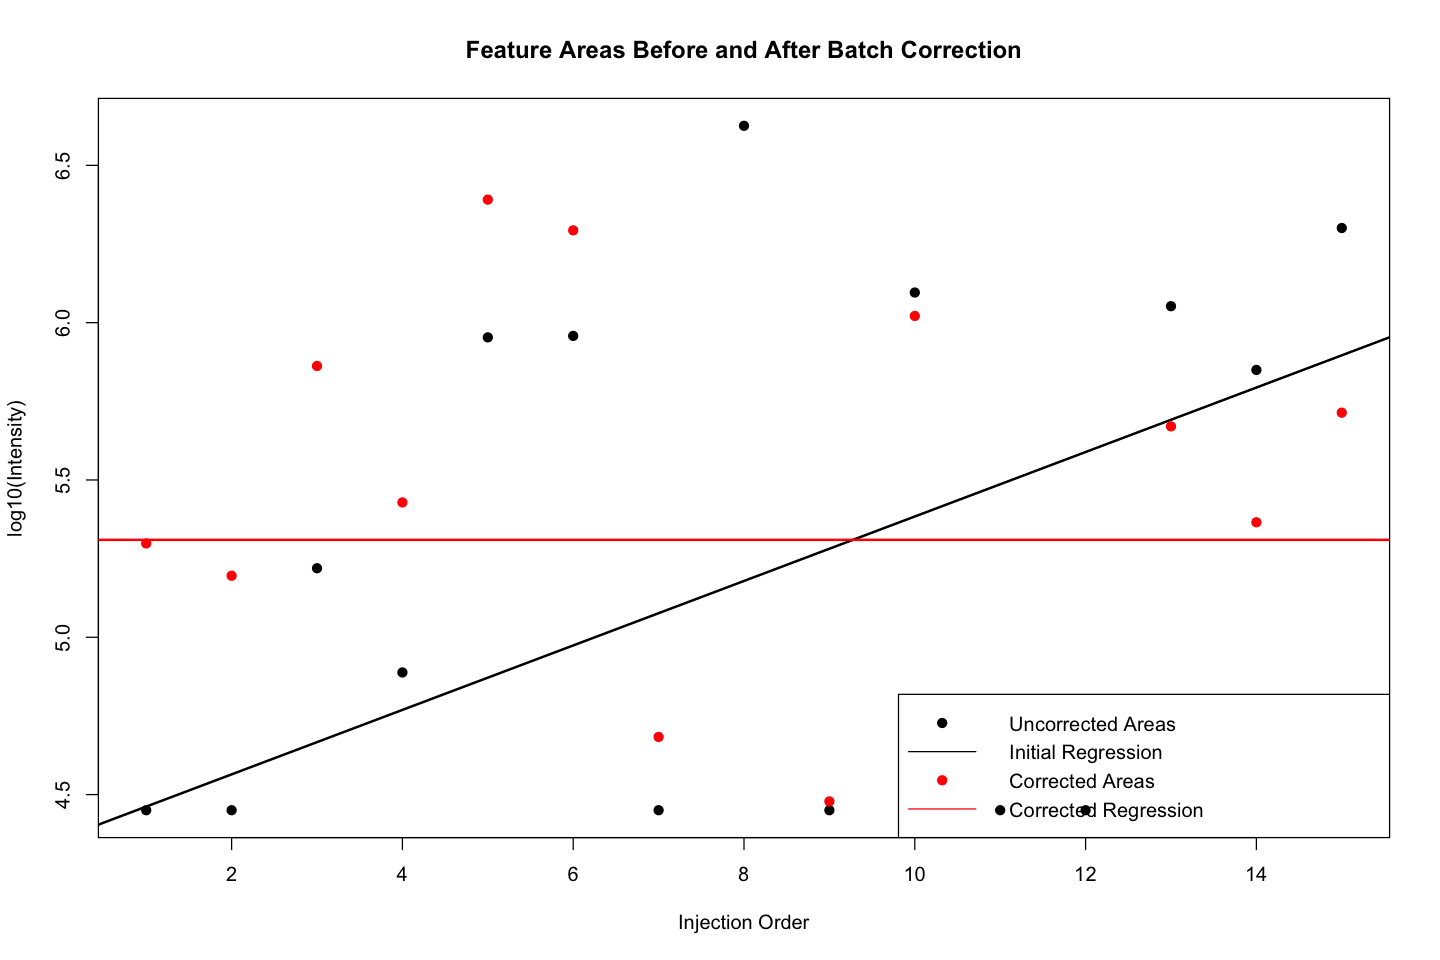

In [37]:
## Plot uncorrected and corrected models and data points
plot(df$order, df$area, col = "black", pch = 19,
     xlab = "Injection Order", ylab = "log10(Intensity)", 
     main = "Feature Areas Before and After Batch Correction")
abline(lm, lwd = 2, col = "black")
points(df$order, df$corr, col = "red", pch = 19)
abline(lm.new, lwd = 2, col = "red")
legend("bottomright", lty = c(NA,1,NA,1), pch=c(19,NA,19,NA),
       legend = c("Uncorrected Areas", "Initial Regression", 
                  "Corrected Areas", "Corrected Regression"), 
       col = c("black", "black", "red", "red"))